In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import os
import time
import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, optimizers, layers, metrics, models, regularizers

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_pickle("Data/df_new.pkl")

In [3]:
print(df.dtypes)

recipient                  object
silo_nr                    object
delivery_date      datetime64[ns]
prod_hier_1                object
prod_hier_2                object
prod_group                 object
prod_group_name            object
delivery_nr               float64
kg_delivered               object
kg_ordered                 object
prev_date          datetime64[ns]
difference                float64
dtype: object


In [4]:
# Turn all columns into the correct type
df["recipient"] = df["recipient"].astype("float32")
df["silo_nr"] = df["silo_nr"].astype("float32")
df["prod_hier_1"] = df["prod_hier_1"].astype("category")
df["prod_hier_2"] = df["prod_hier_2"].astype("category")
df["prod_group"] = df["prod_group"].astype("float32")
df["prod_group_name"] = df["prod_group_name"].astype("category")
df["delivery_nr"] = df["delivery_nr"].astype("float32")
df["kg_delivered"] = df["kg_delivered"].astype("float32")
df["kg_ordered"] = df["kg_ordered"].astype("float32")
df["difference"] = df["difference"].astype("float32")

In [5]:
print(df.dtypes)

recipient                 float32
silo_nr                   float32
delivery_date      datetime64[ns]
prod_hier_1              category
prod_hier_2              category
prod_group                float32
prod_group_name          category
delivery_nr               float32
kg_delivered              float32
kg_ordered                float32
prev_date          datetime64[ns]
difference                float32
dtype: object


In [6]:
eda = df.copy()

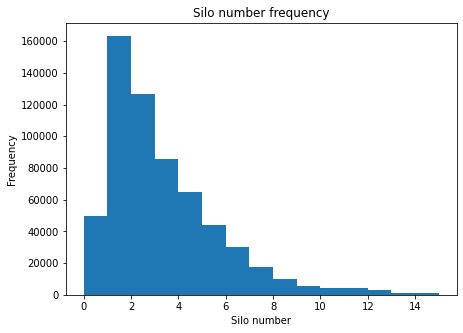

In [7]:
# Plot the distribution of silo numbers
eda["silo_nr"][np.isnan(eda["silo_nr"])] = 0

plt.figure(figsize=(7, 5)).patch.set_facecolor("white")

plt.hist(eda["silo_nr"], bins=15, range=[0,15])
plt.title("Silo number frequency")
plt.xlabel("Silo number")
plt.ylabel("Frequency")
plt.savefig("Plots/silo_nr_frequency.png", bbox_inches="tight")
plt.show()

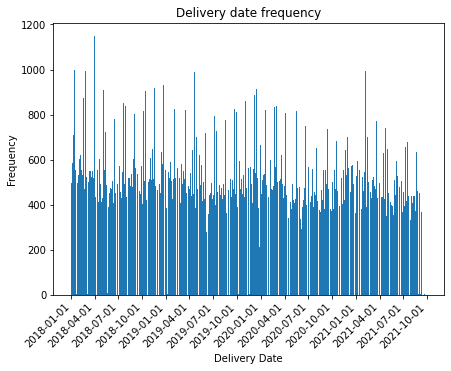

In [8]:
# Plot the distribution of number of orders per day
plt.figure(figsize=(7, 5)).patch.set_facecolor("white")

plt.hist(eda["delivery_date"], bins=1366, range=[pd.Timestamp("2018-01-01"),np.max(eda["delivery_date"])])
plt.title("Delivery date frequency")
plt.xlabel("Delivery Date")
plt.ylabel("Frequency")
plt.xticks(pd.date_range(start="2018-01-01", periods=16, freq="QS"), rotation=45, ha="right")
plt.savefig("Plots/delivery_date_frequency.png", bbox_inches="tight")
plt.show()

In [9]:
# Print how many orders there are before 2018, and how much this is proportionally
before_2018 = [1 if i < pd.Timestamp("2018-01-01") else 0 for i in eda["delivery_date"]]

print(np.sum(before_2018), np.sum(before_2018)/len(eda["delivery_date"]))

5145 0.008345850757696189


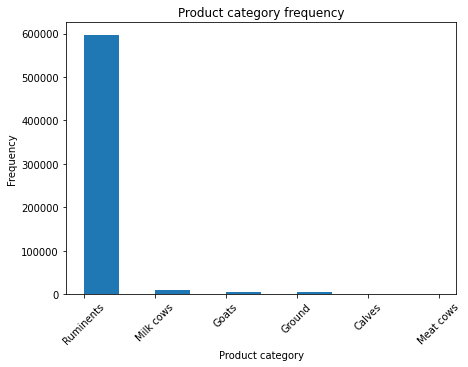

In [10]:
# Plot the distribution of product category
plt.figure(figsize=(7, 5)).patch.set_facecolor("white")

plt.hist(eda["prod_hier_1"])
plt.title("Product category frequency")
plt.xlabel("Product category")
plt.ylabel("Frequency")
plt.xticks(np.arange(6), 
           labels=["Ruminents", "Milk cows", "Goats", "Ground", "Calves", "Meat cows"], rotation=45)
plt.savefig("Plots/prod_hier_frequency.png", bbox_inches="tight")
plt.show()

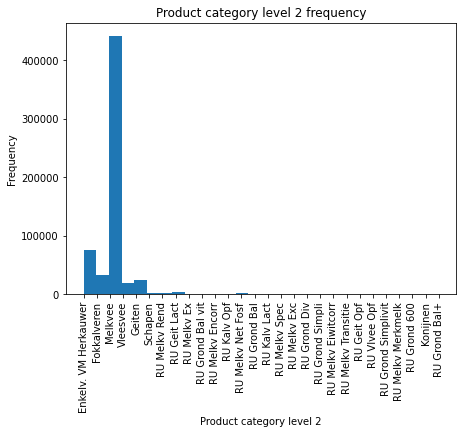

In [11]:
# Plot the distribution of product category level 2
plt.figure(figsize=(7, 5)).patch.set_facecolor("white")

plt.hist(eda["prod_hier_2"], bins=eda["prod_hier_2"].nunique())
plt.title("Product category level 2 frequency")
plt.xlabel("Product category level 2")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.savefig("Plots/prod_hier_2_frequency.png", bbox_inches="tight")
plt.show()

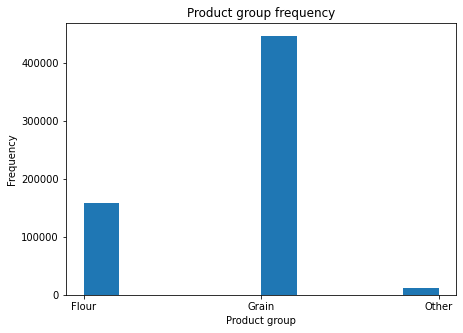

In [12]:
# Plot the distribution of product group
plt.figure(figsize=(7, 5)).patch.set_facecolor("white")

plt.hist(eda["prod_group_name"])
plt.title("Product group frequency")
plt.xlabel("Product group")
plt.ylabel("Frequency")
plt.xticks(np.arange(3), labels=["Flour", "Grain", "Other"])
plt.savefig("Plots/prod_group_frequency.png", bbox_inches="tight")
plt.show()

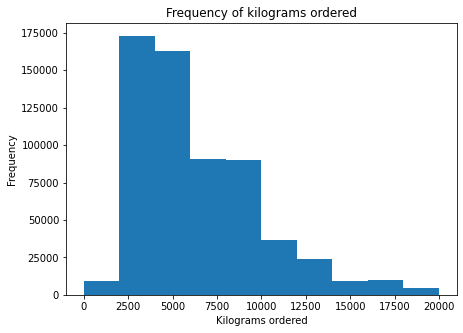

In [13]:
# Print the number of kilograms ordered
res = eda[eda["kg_ordered"] >= 0]
res = res[res["kg_ordered"] <= 35000]

plt.figure(figsize=(7, 5)).patch.set_facecolor("white")

plt.hist(res["kg_ordered"], range=[0,20000])
plt.title("Frequency of kilograms ordered")
plt.xlabel("Kilograms ordered")
plt.ylabel("Frequency")
plt.savefig("Plots/kg_ordered_frequency.png", bbox_inches="tight")
plt.show()

In [14]:
# Print how many orders have an amount of kilograms ordered above 20,000 kilos, and the proportion this is
print(np.max(eda["kg_ordered"]))
print(np.mean(eda["kg_ordered"]))

above = [1 if i > 20000 else 0 for i in eda["kg_ordered"]]

print(np.sum(above), np.sum(above)/len(eda["kg_ordered"]))

150000.0
5773.66748046875
5701 0.009247754163192609


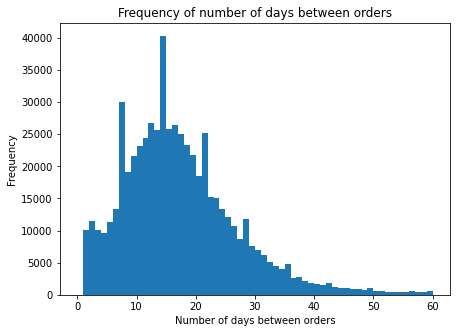

In [15]:
# Plot the distribution for the number of days between two orders
plt.figure(figsize=(7, 5)).patch.set_facecolor("white")

plt.hist(eda["difference"], bins=60, range=[0,60])
plt.title("Frequency of number of days between orders")
plt.xlabel("Number of days between orders")
plt.ylabel("Frequency")
plt.savefig("Plots/difference_frequency.png", bbox_inches="tight")
plt.show()

In [16]:
# Print how many orders have a difference larger than 60, and how much this is proportionally
print(np.max(eda["difference"]))
print(np.mean(eda["difference"]))

above_60 = [1 if i > 60 else 0 for i in eda["difference"]]

print(np.sum(above_60), np.sum(above_60)/len(eda["difference"]))

1179.0
18.603174209594727
9332 0.01513770248218092


In [17]:
# Drop any row without a value for difference
eda.drop(eda[pd.isna(eda.difference) == True].index, inplace=True)
eda.reset_index(drop=True, inplace=True)

In [18]:
# Print some information about the differences in the dataset
print(np.min(eda["difference"]))
print(np.max(eda["difference"]))
print(np.mean(eda["difference"]))
print(np.std(eda["difference"]))
print(np.median(eda["difference"]))

1.0
1179.0
18.603174209594727
23.21724510192871
15.0


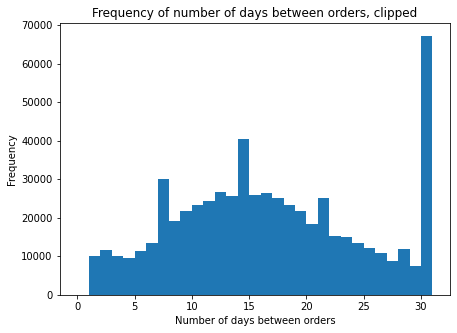

In [19]:
# Plot the distribution of days between orders, clipped
plt.figure(figsize=(7, 5)).patch.set_facecolor("white")

plt.hist(np.asarray(eda["difference"]).clip(min=0, max=31), range=[0,31], bins=31)
plt.title("Frequency of number of days between orders, clipped")
plt.xlabel("Number of days between orders")
plt.ylabel("Frequency")
plt.savefig("Plots/difference_clipped_frequency.png", bbox_inches="tight")
plt.show()

In [20]:
# Create a dictionary with the number of orders as the values, and the customer number as the keys
counter = {}

for i in range(len(eda)):
    if eda["recipient"][i] not in counter:
        counter[eda.loc[i, ("recipient")]] = 1
    else:
        counter[eda.loc[i, ("recipient")]] += 1
        
counter_list = list(counter.values())

In [21]:
# Print information about the number of orders per customer
print(f"Average number of orders: {np.round(np.average(counter_list))}")
print(f"Minimum number of orders: {np.min(counter_list)}")
print(f"Maximum number of orders: {np.max(counter_list)}")
print()

more_than_10 = 0
for i in counter_list:
    if i >= 10:
        more_than_10 += 1
        
print(f"Number of customers with more than ten orders: {more_than_10}")
print(f"Ratio of customers with more than ten orders: {np.round(more_than_10/len(counter_list), 2)}")

Average number of orders: 128.0
Minimum number of orders: 1
Maximum number of orders: 3576

Number of customers with more than ten orders: 4195
Ratio of customers with more than ten orders: 0.88


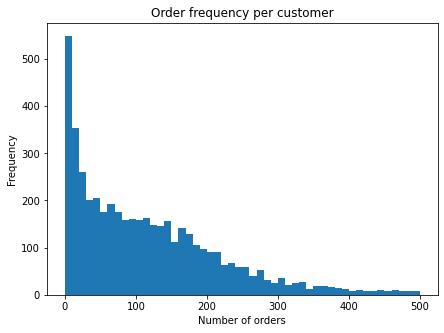

In [22]:
# Plot the distribution of number of orders per customer
plt.figure(figsize=(7, 5)).patch.set_facecolor("white")

plt.hist(counter_list, bins=50, range=[0,500])
plt.title("Order frequency per customer")
plt.xlabel("Number of orders")
plt.ylabel("Frequency")
plt.savefig("Plots/order_frequency.png", bbox_inches="tight")
plt.show()

In [23]:
# Print how many customers have more than 500 orders, and how much this is proportionally
above_500 = [1 if i > 500 else 0 for i in counter_list]

print(np.sum(above_500), np.sum(above_500)/len(counter_list))

93 0.01960370994940978


In [24]:
# Create a list of all customers
recipients = []

for i in eda["recipient"]:
    if i not in recipients:
        recipients.append(i)
        
print(len(recipients))

4744


In [25]:
# Calculate the mean and standard deviation difference for each customer
differences_means = []
differences_stds = []

for i in recipients:
    test_df = eda[eda.recipient == i]
    mean = np.mean(test_df["difference"])
    std = np.std(test_df["difference"])
    
    differences_means.append(mean)
    differences_stds.append(std)

In [26]:
# Print some information about the mean difference for each customer
print(np.min(differences_means))
print(np.max(differences_means))
print(np.mean(differences_means))
print(np.std(differences_means))
print(np.median(differences_means))

1.0
1053.0
37.877370934261236
57.82812312475091
21.373221397399902


In [27]:
# Print some information about the standard deviation difference for each customer
print(np.min(differences_stds))
print(np.max(differences_stds))
print(np.mean(differences_stds))
print(np.std(differences_stds))
print(np.median(differences_stds))

0.0
476.7286071777344
19.340351479068325
36.35605714318686
7.533905744552612


In [28]:
# Print the number of customers with a mean difference above 100, or an sd of above 50
above_100 = [1 if i > 100 else 0 for i in differences_means]
above_50 = [1 if i > 50 else 0 for i in differences_stds]

print(np.sum(above_100), np.round((np.sum(above_100)/len(differences_means)*100),3))
print(np.sum(above_50), np.round((np.sum(above_50)/len(differences_stds)*100),3))

324 6.83
426 8.98


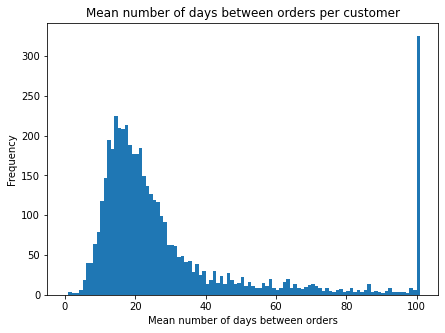

In [29]:
# Plot the mean number of days between orders per customer
plt.figure(figsize=(7, 5)).patch.set_facecolor("white")

plt.hist(np.asarray(differences_means).clip(min=0, max=101), range=[0,101], bins=101)
plt.title("Mean number of days between orders per customer")
plt.xlabel("Mean number of days between orders")
plt.ylabel("Frequency")
plt.savefig("Plots/mean_difference_frequency.png", bbox_inches="tight")
plt.show()

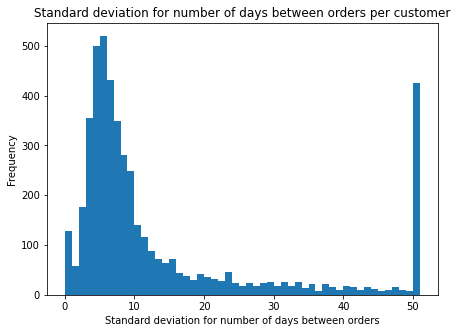

In [30]:
# Plot the standard deviation for number of days between orders per customer
plt.figure(figsize=(7, 5)).patch.set_facecolor("white")

plt.hist(np.asarray(differences_stds).clip(min=0, max=51), range=[0,51], bins=51)
plt.title("Standard deviation for number of days between orders per customer")
plt.xlabel("Standard deviation for number of days between orders")
plt.ylabel("Frequency")
plt.savefig("Plots/std_difference_frequency.png", bbox_inches="tight")
plt.show()

In [31]:
# Calculate the median and interquartile range of the difference for each customer
differences_medians = []
differences_iqrs = []

for i in recipients:
    test_df = eda[eda.recipient == i]
    median = np.median(test_df["difference"])
    q3, q1 = np.percentile(test_df["difference"], [75, 25])
    iqr = q3-q1
    
    differences_medians.append(median)
    differences_iqrs.append(iqr)

In [32]:
# Print some information about the median difference for each customer
print(np.min(differences_medians))
print(np.max(differences_medians))
print(np.mean(differences_medians))
print(np.std(differences_medians))
print(np.median(differences_medians))

1.0
1053.0
34.15957
55.20754
21.0


In [33]:
# Print some information about the interquartile range of the difference for each customer
print(np.min(differences_iqrs))
print(np.max(differences_iqrs))
print(np.mean(differences_iqrs))
print(np.std(differences_iqrs))
print(np.median(differences_iqrs))

0.0
863.0
15.949304384485666
35.97103124881139
8.0


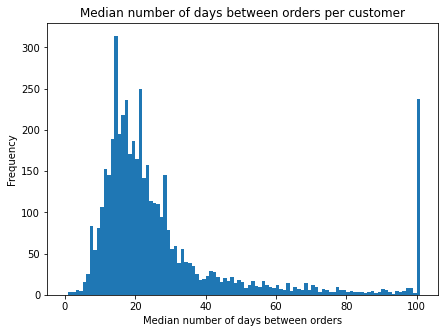

In [34]:
# Plot the distribution of median number of days between orders per customer
plt.figure(figsize=(7, 5)).patch.set_facecolor("white")

plt.hist(np.asarray(differences_medians).clip(min=0, max=101), range=[0,101], bins=101)
plt.title("Median number of days between orders per customer")
plt.xlabel("Median number of days between orders")
plt.ylabel("Frequency")
plt.savefig("Plots/median_difference_frequency.png", bbox_inches="tight")
plt.show()

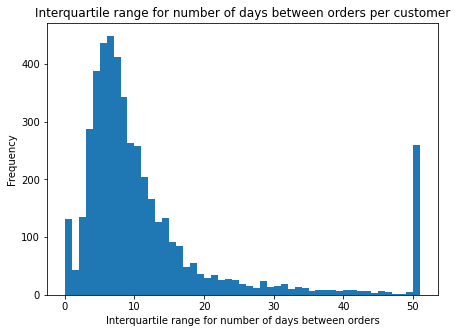

In [35]:
# Plot the distribution of interquartile ranges for the number of days between orders per customer
plt.figure(figsize=(7, 5)).patch.set_facecolor("white")

plt.hist(np.asarray(differences_iqrs).clip(min=0, max=51), range=[0,51], bins=51)
plt.title("Interquartile range for number of days between orders per customer")
plt.xlabel("Interquartile range for number of days between orders")
plt.ylabel("Frequency")
plt.savefig("Plots/iqr_difference_frequency.png", bbox_inches="tight")
plt.show()